In [5]:
# Import Libs
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm

### Import Data

In [11]:
df = pd.read_excel("BeerData.xlsx",sheet_name = 'data', skiprows=0)
df

,name,type,category,abv,ibu,srm,og,fg,rs,master_type,new_master,new_category
0,Challenge Accepted American Amber Ale,American Amber Ale,Beer,5.7,33.0,15.0,1.056,1.014,0.042,Ale,Ale,Ale
1,Horizon Pale Ale,American Pale Ale,Beer,6.5,57.0,7.0,1.057,1.009,0.048,Ale,Ale,Ale
2,One Way or Another Guava Blonde Ale,Fruit Beer,Beer,3.4,18.0,4.0,1.032,1.006,0.026,Ale,Ale,Ale
3,Old Man Johnson’s Farm Catharina Sour,Sour Ale,Beer,5.1,7.0,4.0,1.045,1.006,0.039,Ale,Ale,Ale
4,Kilt Dropper Wee Heavy,Amber Ale,Beer,8.9,26.0,20.0,1.083,1.020,0.063,Ale,Ale,Ale
...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Three Witches Wood-Aged Beer,Wood-aged Beer,Beer,9.6,29.0,17.0,1.102,1.031,0.071,Unspecified,Unspecified,Unspecified
1172,Chipotle Lichtenhainer,Spice & Herb Beer,Beer,4.5,5.0,3.0,1.042,1.008,0.034,Unspecified,Unspecified,Unspecified
1173,Eis Eis Baby Wood-Aged Beer,Wood-aged Beer,Beer,11.0,29.0,14.0,1.107,1.033,0.074,Unspecified,Unspecified,Unspecified
1174,Goats in a Tree in a Mezcal Barrel,Wood-aged Beer,Beer,8.4,18.0,24.0,1.087,1.023,0.064,Unspecified,Unspecified,Unspecified


In [12]:
df.sample()

,name,type,category,abv,ibu,srm,og,fg,rs,master_type,new_master,new_category
279,Trappist Tripel,Belgian Ale,Beer,9.5,35.0,5.0,1.079,1.008,0.071,Ale,Ale,Ale


### Check expected data has been loaded

In [13]:
# Find the number of columns and rows
df.shape

(1176, 12)

In [249]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1176 non-null   object 
 1   type          1176 non-null   object 
 2   category      1176 non-null   object 
 3   abv           1176 non-null   float64
 4   ibu           1142 non-null   float64
 5   srm           1176 non-null   float64
 6   og            1176 non-null   float64
 7   fg            1176 non-null   float64
 8   rs            1176 non-null   float64
 9   master_type   1176 non-null   object 
 10  new_master    1176 non-null   object 
 11  new_category  1176 non-null   object 
dtypes: float64(6), object(6)
memory usage: 110.4+ KB


In [250]:
df['new_category'].value_counts()

new_category
Ale            858
Lager          115
Mead            83
Hybrid          64
Cider           34
Unspecified     22
Name: count, dtype: int64

#### Split To Ale
The large number of entries in the Ale new_category would likely ensure a robust model, and so the data was reduced to only Ale for the initial regression model. The below code block can be adjusted to run the model for other categories.

In [251]:
## Extract only Ale
df = df[df['new_category'] == 'Ale']

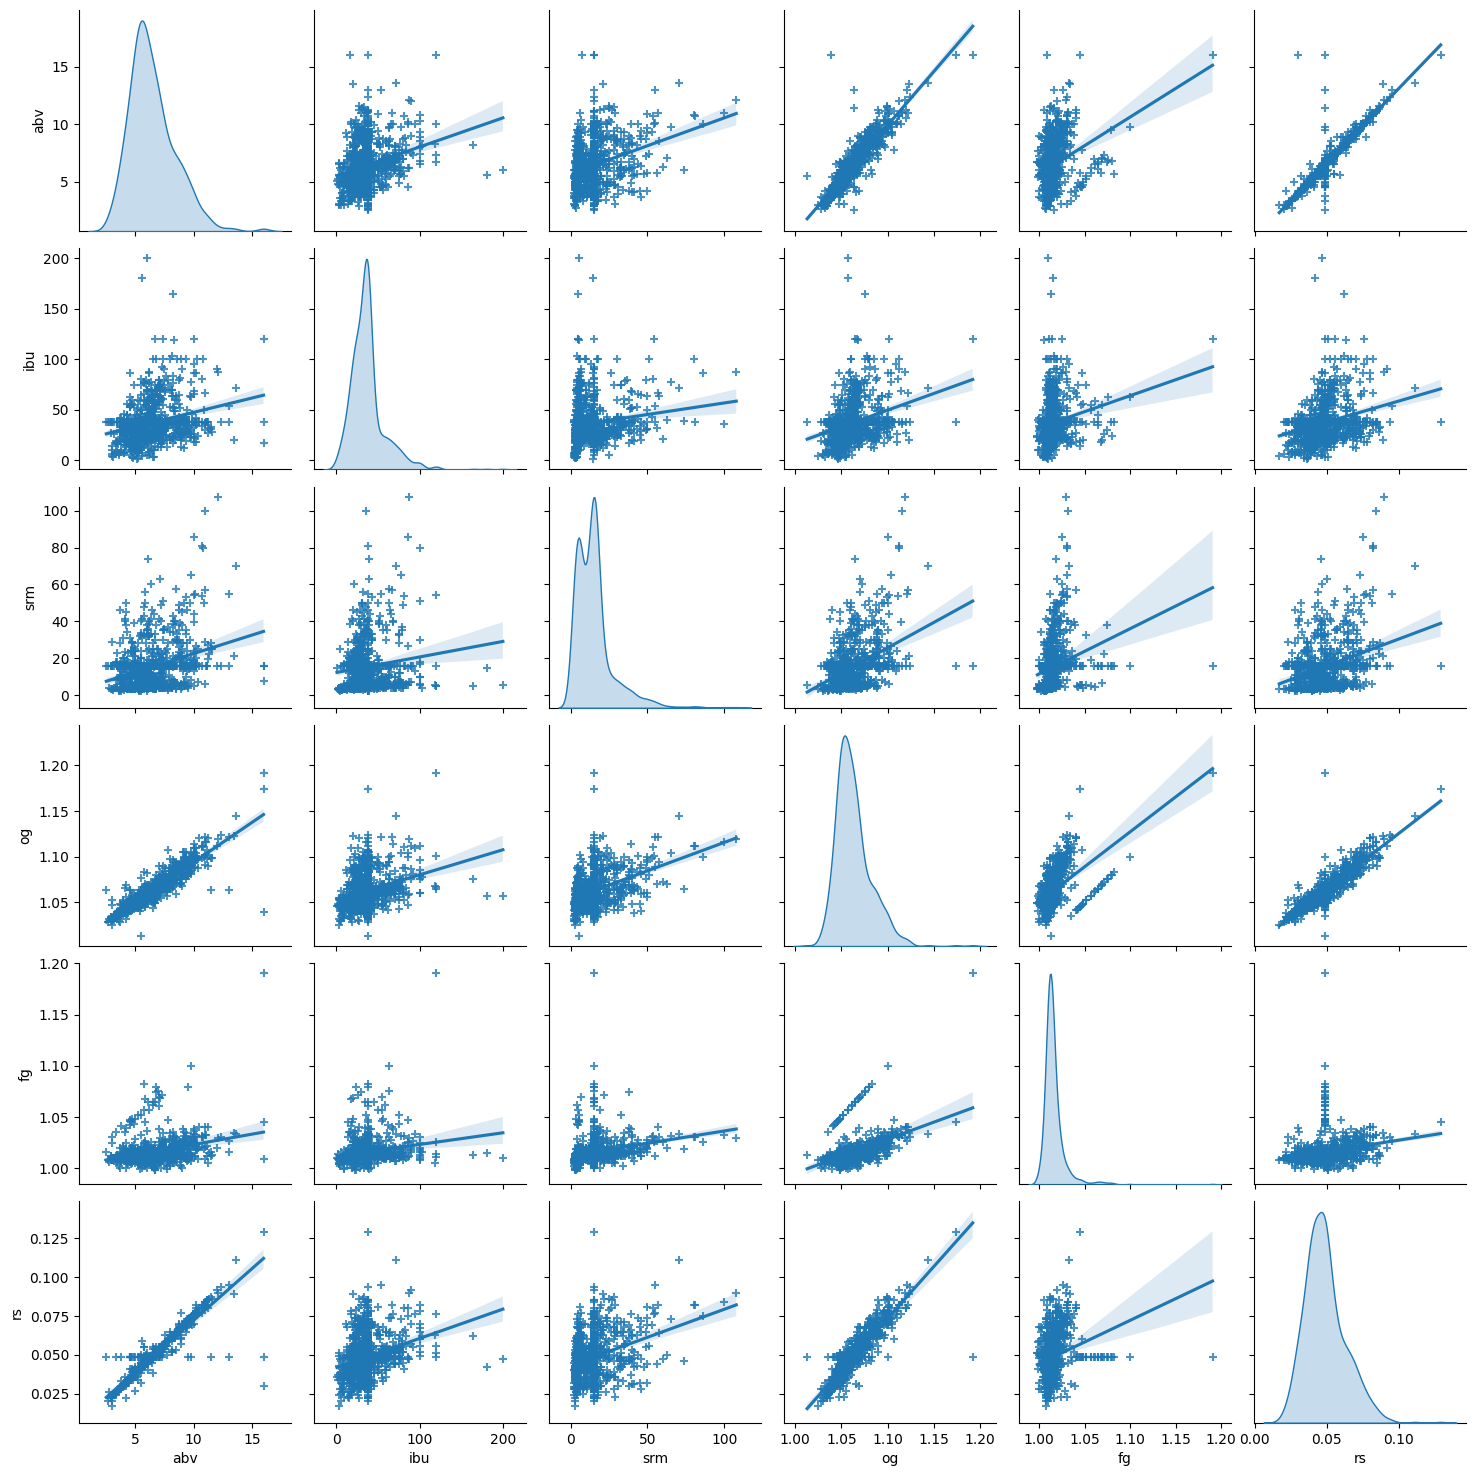

In [252]:
# Create a pairplot to visualise the relationships between our variables & the distributions of our data
sns.pairplot(df, diag_kind='kde', kind='reg', markers='+')

The intention of this regression model is to determine the factors that can predict abv levels (the dependant variable), so I need to consider which other datapoint to use as the independent variable. It is common knowledge that sugar and alcohol are related as sugar is eaten by active yeast to produce alcohol, so that is the most likely candidate which confirmed in the above pairplot. It seems that Rs (Residual Sugar) is also a viable option, however this is a byproduct of the brewing process (the left over sugar in the drink) and so can't be used as a predictor. I suspect that Og and Rs are closely related, I can see that better in a heatmap.

## Heatmap

In [253]:
dfnum = df.select_dtypes(exclude=['object']) ## Drop all non numerical dtypes

In [254]:
##Correlaton Matrix
dfnum.corr()

,abv,ibu,srm,og,fg,rs
abv,1.000000,0.267507,0.312264,0.902800,0.316737,0.929304
ibu,0.267507,1.000000,0.139081,0.301130,0.190072,0.280017
srm,0.312264,0.139081,1.000000,0.414767,0.243407,0.325999
og,0.902800,0.301130,0.414767,1.000000,0.504604,0.903349
fg,0.316737,0.190072,0.243407,0.504604,1.000000,0.249213
rs,0.929304,0.280017,0.325999,0.903349,0.249213,1.000000


<Axes: >

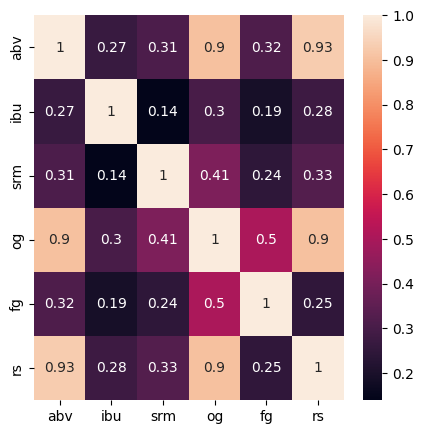

In [255]:
plt.figure(figsize=(5, 5))
sns.heatmap(dfnum.corr(), annot=True)

This heatmap confirms a high correlation coefficient between abv and og (0.89) suggesting that a linear regression model could capture this relationship well.  There is multicollinearity between Og and Rs which makes sense in this context as Resitual Sugar (Rs) will be directly related to the amount of sugar added in the Og measurement.  This would only be an issue if I were to use these values in a multiple lenear regression.

## Simple Linear Regression - Run 1

### Split the dependent and independent variables

In [256]:
# Split the independent and dependent variables into X and y
X = df[['og']]
y = df['abv']

In [257]:
# Check the shapes
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (858, 1)
y shape: (858,)


### Split the data into 80/20 train/test

In [258]:
# Perform the train/test split with random_state=23
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [259]:
# Check the shapes
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (686, 1)
y_train: (686,)
X_test: (172, 1)
y_test: (172,)


### Examine and interpret the coefficients

In [260]:
# Define the model variable
lin_reg = LinearRegression()

In [261]:
# Fit it
lin_reg.fit(X_train, y_train)

LinearRegression()

In [262]:
# View the intercept
lin_reg.intercept_

-92.0953732732754

That seems unlikely!  The model is suggesting that if no sugar is added, the end alcohol level will reach -91% which isn't possible.  The likely explanation for this is that the model, though it appears to suit linear regression would be best suited to polynomial regression at low alcohol levels.  The model also wouldn't account for natural sugars that would occure in other ingredients, meaning that the abv would never be zero.  As none of the drinks in the sample were alcohol free (though these would still contain trace alcohol) I can't explore that easily, but I am comfortable that the model will be fine for alcoholic drinks.

In [263]:
# View the slope
lin_reg.coef_

array([92.71873126])

Another unexpected result! The model is suggesting here that for every unit of sugar that is added, the alcohol will increase by 92%.  This is most likely because the two features are on different scales, I will scale the data and see if this improves.

### Scale the data

Only numerical data can be scaled so I will use the dfnum dataframe used for the heatmap.

In [264]:
# Initialize the MinMaxScaler
##scaler = MinMaxScaler()

# StandardScaler
scaler = StandardScaler()

# RobustScaler
##scaler = RobustScaler()

# Normalize the data
normalised_data = scaler.fit_transform(dfnum)

# Create a new DataFrame with the normalized data
df_normalised = pd.DataFrame(normalised_data, columns=dfnum.columns)

print("Normalised DataFrame:")
print(df_normalised)

Normalised DataFrame:
          abv       ibu       srm        og        fg        rs
0   -0.375742 -0.214489 -0.025160 -0.359522 -0.149515 -0.477875
1    0.029372  0.934782 -0.655702 -0.307051 -0.547520 -0.051901
2   -1.540445 -0.932783 -0.892155 -1.618827 -0.786323 -1.613805
3   -0.679577 -1.459532 -0.892155 -0.936703 -0.786323 -0.690862
4    1.244714 -0.549693  0.368929  1.057195  0.328091  1.013033
..        ...       ...       ...       ...       ...       ...
853  2.389161  0.007566  0.015331  2.316499  0.487293  2.574936
854 -1.003669  0.007566  0.015331 -0.779290 -0.149515 -1.045840
855 -0.735281  0.007566  0.015331 -0.726819 -0.388318 -0.761858
856  2.323330  0.007566  0.015331  2.788739  1.283303  2.503941
857  1.391568  0.007566  0.015331  1.529434  0.487293  1.510002

[858 rows x 6 columns]


## Simple Linear Regression - Run 2

### Split the dependent and independent variables

In [265]:
# Split the independent and dependent variables into X and y
X_normalised = df_normalised[['og']]
y_normalised = df_normalised['abv']

In [266]:
# Check the shapes
print('X shape:', X_normalised.shape)
print('y shape:', y_normalised.shape)

X shape: (858, 1)
y shape: (858,)


### Split the data into 80/20 train/test

In [267]:
# Perform the train/test split with random_state=23
X_train, X_test, y_train, y_test = train_test_split(X_normalised, y_normalised, test_size=0.2, random_state=23)

In [268]:
# Check the shapes
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (686, 1)
y_train: (686,)
X_test: (172, 1)
y_test: (172,)


### Examine and interpret the scaled coefficient

In [269]:
# Define the model variable
lin_reg = LinearRegression()

In [270]:
# Fit it
lin_reg.fit(X_train, y_train)

LinearRegression()

In [271]:
# View the intercept
lin_reg.intercept_

0.00450802136460763

In [272]:
# View the slope
lin_reg.coef_

array([0.89481914])

These numbers look more realistic on the scaled data but I will need to scale them back to get anything interpretable.

### Scale back to see the coefficients

In [273]:
# Get the coefficients and intercept from the model
coef_normalized = lin_reg.coef_[0]
intercept_normalized = lin_reg.intercept_

# Inverse transform the coefficients and intercept to original scale
coef_original = coef_normalized * (df['abv'].max() - df['abv'].min()) / (df['og'].max() - df['og'].min())
intercept_original = intercept_normalized * (df['abv'].max() - df['abv'].min()) + df['abv'].min() - coef_original * df['og'].min()

print(f"Original Coefficient: {coef_original}")
print(f"Original Intercept: {intercept_original}")

Original Coefficient: 67.48635968742961
Original Intercept: -65.802824074944


This still looks incorrect, but  this is becasue as standard, the coefficient is generated for every 1 unit increase in the independent variable, but as my units are so small, the increments on this axis need to be 100 times smaller. 

In [274]:
# Get the coefficients and intercept from the model
coef_normalized = lin_reg.coef_[0]
intercept_normalized = lin_reg.intercept_

# Inverse transform the coefficients and intercept to original scale
coef_original = coef_normalized * (df['abv'].max() - df['abv'].min()) / (df['og'].max() - df['og'].min())*0.01
intercept_original = intercept_normalized * (df['abv'].max() - df['abv'].min()) + df['abv'].min() - coef_original * df['og'].min() *0.01

print(f"Original Coefficient: {coef_original}")
print(f"Original Intercept: {intercept_original}")

Original Coefficient: 0.6748635968742961
Original Intercept: 2.5540219201858663


I added * 0.01 to the rescaling lines to muplitply my standard coeficient by 0.01 and show the increase for every 0.01 unit increase of Og. Though the intercept is more realistic now (assuming a natural level of sugar in other ingredients would create an ale of a low alcohol content) achieving 2.6% Abv with no added sugar is likely inaccurate as there are non alcolic ales on the market with just trace alcohol levels.  As I stated earlier, accuracy for low alcohol levels may be improved with a polynomial regression, though that would require more data with ales in the 0% to xxx% Abv range.  

However the final result for the coefficient are that there is an increase of 0.67% Abv for every 0.01 increase in Og.  This information can be used to optimise brewing techniques to hit tax thresholds and refine brewing optimisation.

## Modelling

### Generate predictions for the test set

In [275]:
# Create X and y variables
X = df[['og']]
y = df['abv']

In [276]:
## Test and Train - 80% Train 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=423)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (686, 1)
X_test shape: (172, 1)
y_train shape: (686,)
y_test shape: (172,)


In [277]:
# Train a simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

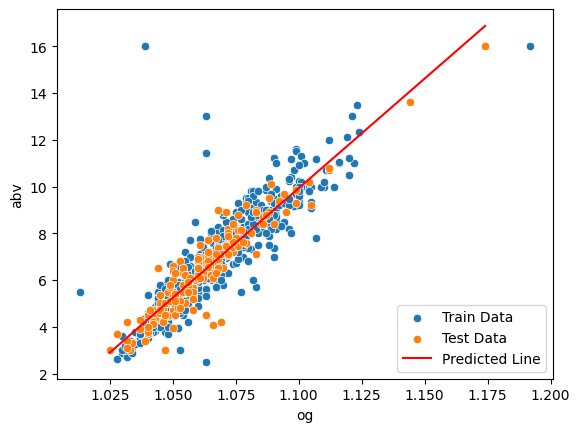

In [278]:
preds = lin_reg.predict(X_test)

sns.scatterplot(x=X_train['og'], y=y_train, label='Train Data')
sns.scatterplot(x=X_test['og'], y=y_test, label='Test Data')
sns.lineplot(x=X_test['og'], y=preds, color='red', label='Predicted Line')

plt.legend()
plt.show()

### Calculate error metrics

In [279]:
# Calculate predictions for the train set
preds_train = lin_reg.predict(X_train)

In [280]:
# Calculate predictions for the test set
preds_test = lin_reg.predict(X_test)

In [281]:
# Calculate and print metrics
mae = mean_absolute_error(y_test, preds_test)
rmse = mean_squared_error(y_test, preds_test)

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 0.4861422828376704
RMSE: 0.4619438551355548


The Mean Absolute Error Value only appears to deviate by around 0.49 units which means the model is quite accurate and with the Root Mean Squared Error being 0.46 it seems that the models predictions are close to actual values with few major deviations or errors. Overall, the model is performing well and making accurate predictions.

### Checking R Squared 

In [282]:
## Model summary
X = sm.add_constant(X)
lin_reg = sm.OLS(y, X)
model = lin_reg.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    abv   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     3772.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          6.04e-316
Time:                        16:17:46   Log-Likelihood:                -1077.3
No. Observations:                 858   AIC:                             2159.
Df Residuals:                     856   BIC:                             2168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -92.9832      1.619    -57.430      0.000     -96.161     -89.805
og            93.5457      1.523     61.418      0.000      90.556      96.535
==============================================================================
Omnibus:                      797.360   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86636.119
Skew:                           3.767   Prob(JB):                         0.00
Kurtosis:                      51.648   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R squared and Adjusted R Squared scores of 0.815, mean that 82% of the variability in Abv can be explained by the Original Gravity even when adjusting for the predictors in the model, which is pretty good and overall I'm satisfied that it is performing well.

I am aware that formulas have existed for many years that aim to predict the alcohol content of ale from the original gravity and a good next step to verify the performance would be to benchmark this model against real life examples and test each method.

If I were to improve this model I would consider incorporating other features such as brewing time, temperature or yeast content into a multiple regression model, however all the remaining features in the dataset are byproducts of the brewing porcess and can't be adjusted before fermentation, so I would need a larger dataset to do this.